In [1]:
library(ggplot2)
library(dplyr)
library(gplots)
library(ggpmisc)
library(ggpubr)
library(reshape2)
library(umap)
library(ggExtra) 
library(pals)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)
library(heatmap.plus)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: ggpp


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate


Registered S3 method overwritten by 'ggpmisc':
  method                  from   
  as.character.polynomial polynom

Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    gen

In [2]:
library(maftools)

In [3]:
raw<-read.table(file="./Bioskryb_DNA_final_summary.txt",header=T)
variant_anno<-read.csv(file="../../variant_annotation/780_variant_annotation_by_all_samples.csv",header=T)

In [4]:
colnames(raw)
colnames(variant_anno)

[1] "ID"                        "PLATE"                    
 [3] "SAMPLE"                    "CHROM"                    
 [5] "POS"                       "REF"                      
 [7] "ALT"                       "INDIVIDUAL"               
 [9] "CHROM.POS.REF.ALT"         "Mosaic"                   
[11] "ANNO"                      "GENE"                     
[13] "GNOMAD_FREQ"               "REPEAT_MASKER"            
[15] "SEGDUP"                    "HOMOPOLYMER"              
[17] "REF_SEQ"                   "DINUCLEOTIDE"             
[19] "NEAR_INDEL"                "UCSC_RPMSK"               
[21] "DEPTH"                     "REF_COUNT"                
[23] "ALT_COUNT"                 "MAF"                      
[25] "LOWER_CI"                  "UPPER_CI"                 
[27] "CI_IS_GREATER"             "NORMAL_REF_COUNT"         
[29] "NORMAL_ALT_COUNT"          "NORMAL_MAF"               
[31] "NORMAL_LOWER_CI"           "NORMAL_UPPER_CI"          
[33] "NORMAL_CI_IS_GREATER"      "Mosaic_shared_btw_WGS_Amp"
[35] "BINARY"                    "Cell_Type"

[1] "X"                       "variant_list"           
 [3] "sample_number_presented" "HEART"                  
 [5] "ADRENAL"                 "CB"                     
 [7] "CTX"                     "LIVER"                  
 [9] "KIDNEY"                  "POA"                    
[11] "BG"                      "THAL"                   
[13] "SKIN"                    "OLF"                    
[15] "HIP"                     "L"                      
[17] "R"                       "I"                      
[19] "F"                       "P"                      
[21] "O"                       "T"                      
[23] "Cau"                     "Put"                    
[25] "Thal"                    "GP"                     
[27] "Hip"                     "EC"                     
[29] "Olf"                     "CC"                     
[31] "mO"                      "Cb"                     
[33] "DLX1"                    "TBR1"                   
[35] "COUPTF2"                 "Bulk"                   
[37] "NeuN"                    "Brain_only"             
[39] "CTX_only"                "BG_only"                
[41] "THAL_only"               "CTX_BG_only"            
[43] "CTX_BG_shared"           "CTX_HIP_shared"         
[45] "HIP_BG_shard"            "CTX_THAL_shared"        
[47] "Left_only"               "Right_only"             
[49] "IN_only"                 "COUP_only"              
[51] "TBR_only"                "TBR_BR"                 
[53] "DLX_BR"                  "HIP_only"               
[55] "HIP_BG_shared"

In [5]:
filtered<-subset(raw, Cell_Type %in% c("ExN","InN","U"))

In [6]:
unique(filtered$Mosaic_shared_btw_WGS_Amp)

[1] 1 0

In [7]:
raw$BINARY<-0
raw$BINARY[raw$NORMAL_UPPER_CI<raw$LOWER_CI]<-1
#raw$BINARY[raw$NORMAL_UPPER_CI>=raw$LOWER_CI | raw$LOWER_CI<=0.05]<-0
length(unique((raw[raw$BINARY==1,]$CHROM.POS.REF.ALT)))

[1] 1187

# heatmap

In [29]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered2 <- subset(raw, BINARY %in% c(1) &
                   Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1 
                                                       # (variant_anno$R==1 & variant_anno$IN_only==1) | (variant_anno$R==1 & variant_anno$CTX_BG_shared==1)
                                                       # (variant_anno$Right_only==1 & variant_anno$T==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$F==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$HIP==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$CTX_BG_shared==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$CTX_HIP_shared==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$HIP_BG_shard==1) 
                                                       ,]$variant_list &
                   Cell_Type %in% c("ExN","InN") & PLATE %in% c("PL01","PL02"))

# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered2$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered2$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered2$CHROM.POS.REF.ALT)
for (i in unique(filtered2$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered2, CHROM.POS.REF.ALT==i))
}

# filter out high AF MVs
filtered2<-subset(filtered2, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<15 & recurrency$Recurrency>1,]$variant)

In [30]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered <- subset(raw, SAMPLE %in% filtered2$SAMPLE &
                   CHROM.POS.REF.ALT %in% filtered2$CHROM.POS.REF.ALT &
                   Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   #CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1,]$variant_list &
                   Cell_Type %in% c("ExN","InN") & PLATE %in% c("PL01","PL02"))

In [31]:
# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered$CHROM.POS.REF.ALT)
for (i in unique(filtered$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered, CHROM.POS.REF.ALT==i &  BINARY==1))
}

In [32]:
# filter out high AF MVs
filtered<-subset(filtered, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<15 & recurrency$Recurrency>1,]$variant)

In [33]:
#description of filtered data frame 
print(paste("number of variants:", length(unique(filtered$CHROM.POS.REF.ALT))))
print(paste("number of cells:", length(unique(filtered$SAMPLE))))
print(paste("number of Excitatory neurons:", length(unique(filtered[filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of Inhibitory neurons:", length(unique(filtered[filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of cells in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01",]$SAMPLE))))
print(paste("number of cells in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02",]$SAMPLE))))
print(paste("number of cells in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03",]$SAMPLE))))
print(paste("number of ExN in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of ExN in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of ExN in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of InN in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01" & filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of InN in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02" & filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of InN in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03" & filtered$Cell_Type=="InN",]$SAMPLE))))

[1] "number of variants: 68"
[1] "number of cells: 118"
[1] "number of Excitatory neurons: 85"
[1] "number of Inhibitory neurons: 33"
[1] "number of cells in Frontal lobe: 56"
[1] "number of cells in Temporal lobe: 62"
[1] "number of cells in Hippocampus: 0"
[1] "number of ExN in Frontal lobe: 40"
[1] "number of ExN in Temporal lobe: 45"
[1] "number of ExN in Hippocampus: 0"
[1] "number of InN in Frontal lobe: 16"
[1] "number of InN in Temporal lobe: 17"
[1] "number of InN in Hippocampus: 0"


In [39]:
melt_mtcars<-filtered[,c("ID","PLATE", "CHROM.POS.REF.ALT", "BINARY", "Cell_Type")]

In [51]:
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+PLATE+Cell_Type~CHROM.POS.REF.ALT, value.var = "BINARY", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1]
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$PLATE)
unique(casted_MAF_VarBySample2$Cell_Type)

[1] 118

[1] "PL01" "PL02"

[1] "ExN" "InN"

In [43]:
length(colnames(casted_MAF_VarBySample2))

[1] 70

In [44]:
cleaned_data<-casted_MAF_VarBySample2[rowSums(casted_MAF_VarBySample2[,-1:-2])>0,]

In [45]:
Normalized_casted_MAF_VarBySample2<-t((t(cleaned_data[,-1:-2])))
label<-t(t(cleaned_data[,1:2]))
label<-as.data.frame(label)

In [46]:
left_right_cell_col_ann <- HeatmapAnnotation(simple_anno_size = unit(0.5, "cm"), 
                                             which = "row",
                                             #Hemisphere = label$Hemisphere,
                                             PLATE = label$PLATE,
                                             Cell_Type = label$Cell_Type,
                                             col = list(PLATE = c("PL01"="#CBDF00","PL02"="#00DF3D","PL03"="#9200DF"),
                                                        Cell_Type = c("InN" = "#EF6666", "ExN" = "#7CBD42", "Other" = "blue"))
                                             )

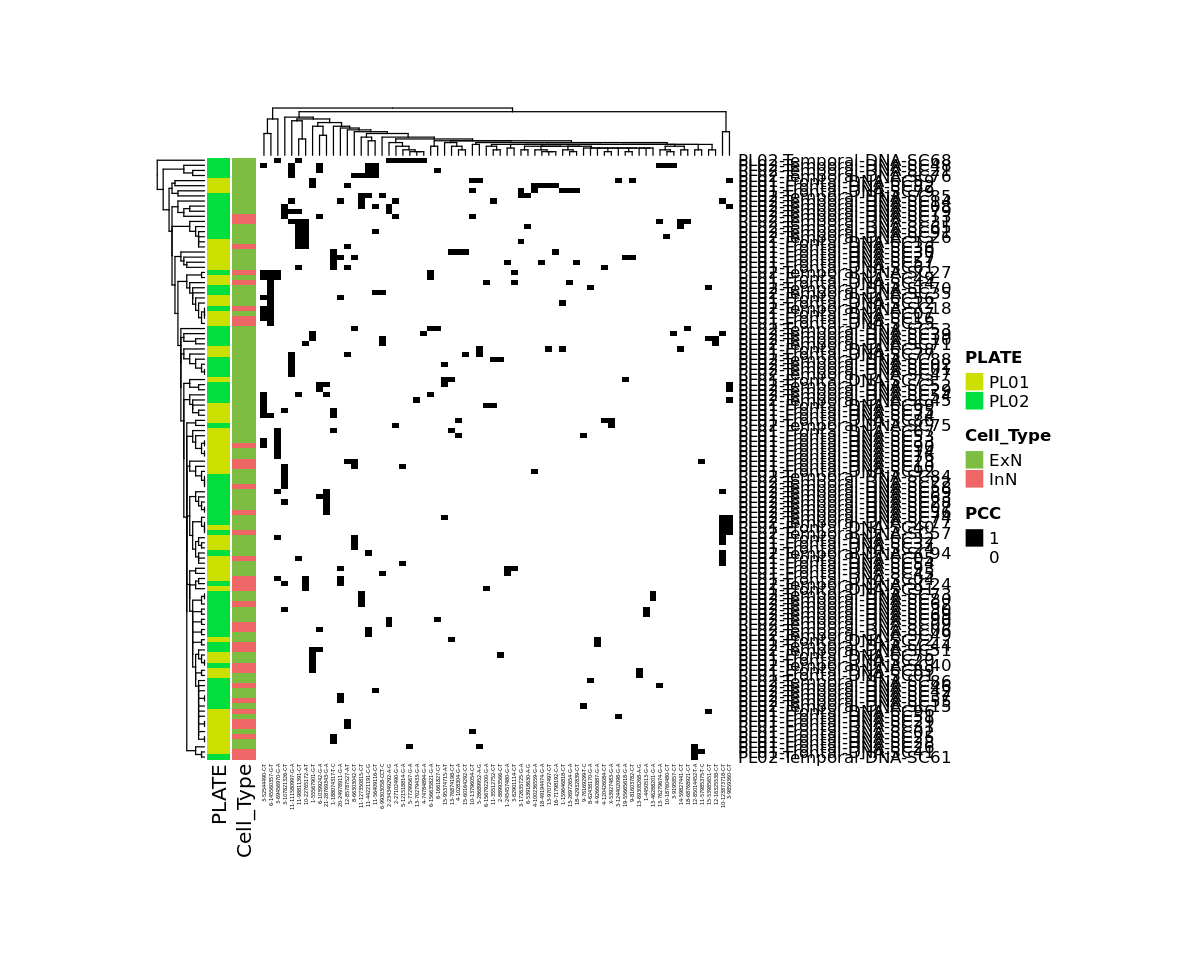

In [57]:
options(repr.plot.width = 10, repr.plot.height = 8)
p<-Heatmap(Normalized_casted_MAF_VarBySample2,
        col = c("white", "black"),
        row_names_gp = gpar(fontsize = "10"), column_names_gp = gpar(fontsize = "3"),
        name = "PCC",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(10, "cm"),
        heatmap_height = unit(15, "cm")) 
p

In [58]:
pdf(file="ResolveOME_DNA2_2_SampleByVar_heatmap.pdf",height=8,width=10)
p
dev.off()   

png 
  2